## 网站转化率的评估

A/B 测试是一种用来检测两种不同处理方式导致的差异化程度的统计模式。例如，一个前端网站的开发者想知道他所开发的两个网站中，谁会带来更高的转化率。这里转化可以理解为用户注册、购买或其他的行为。他们会抽取一定比例的用户使用网站 A ，另外一定比例的用户使用网站 B。并且记录下这些用户的转化行为。本实验将会利用贝叶斯推断对上述两个网站的真实转换率进行推断。

- 贝叶斯 A/B 测试
- 网站的转换率评估
- 数据的真实差异性比较
- 伯努利分布
- 数据的可视化

假设有 N 个用户浏览了网站 A，n 个用户转化了。我们可能会草率的得到 $P_A=\frac{n}{N}$。然而，事实上，观测频率 $\frac{n}{N}$ 并不一定等于 $P_A$。因为在真实频率和观测频率之间还是存在一些区别的。

真实数据可以理解为一件事情发生的概率，而观测频率只是频率而已。举个例子，众所周知，骰子的数字 1 朝上的真实频率为 $\frac{1}{6}$。但是，事实上，就算我们实验六次，也不一定能观测到数字为 1 的那一面（这就是观测频率）。

在现实生活中，真实频率的前面经常会出现很多的噪音以及其他复杂情况的干扰。因此，我们最好是使用观测到的数据以及合理的先验知识，来推断真实频率的可能值。这样得到的转化率才更加接近真实。

- 假设一个真实频率 $P_A$，并且利用这个概率，产生观测数据。
- 通过观测数据得到观测频率，并与 $P_A$ 比较，证实观测频率并不等于真实概率的结论。
- 通过观测数据和贝叶斯推断，得到 $P_A$ 的后验概率，并与真实频率比较。证实贝叶斯推断可以求取真实频率的结论。

假设有 1500 个用户访问了网站 A，真实 $P_A$ = 0.05。现在，我们使用 **伯努利分布** 来对他们的行为进模拟，产生观测数据。

简单的说，伯努利分布是一个二项随机值。也就是说，它产生的数据为 0 或 1。即对应着，该用户没有发生转化行为 或 发生了转化行为。换个正式的说法就是，伯努利分布的分布函数如下所示：
$$X\ \sim \text{Ber}(p)$$

该分布所需要的参数就是真实概率 $P_A$。我们可以通过真实的概率，模拟观测数据。代码如下：

In [1]:
import scipy.stats as stats
import numpy as np
# 请记住，这个真实概率其实是未知的
# 也就是说，后面我们其实是需要使用贝叶斯推断来得到这个 p_true 的值的
p_true = 0.05
N = 1500

occurrences = stats.bernoulli.rvs(p_true, size=N)

print("每个人是否发生转化：", occurrences)  # 0表示未发生转化，1表示发生转化
print("发生转化行为的人数：", np.sum(occurrences))

每个人是否发生转化： [0 0 0 ... 0 0 0]
发生转化行为的人数： 73


In [2]:
print("A 网站的观测频率为： %.4f" % np.mean(occurrences))
print("该转化率和真实的转化率相同吗? %s" % (np.mean(occurrences) == p_true))

A 网站的观测频率为： 0.0487
该转化率和真实的转化率相同吗? False


#### 利用贝叶斯推断真实转化率

还记得上一个试验中，贝叶斯推断的步骤吗？在建立贝叶斯模型时，我们首先需要对未知变量赋予一个先验分布（即在进行任何实验前，我们所认为的网站 A 的转化率），然后利用已知数据与模型对它的后验分布（即真实转化率）进行求取。

然而，在这个例子中，我们对 $P_A$ 的先验概率并不确定。因此，在这里，我们先假设 $P_A$ 来自 [0,1] 的均匀分布（可以理解为 $P_A$ 为所有值的概率相同，并没有任何倾向）。让我们利用 PyMC 将它定义出来：

In [3]:
import pymc3 as pm

model = pm.Model()
with model:
    # 0-1 的均匀分布
    p = pm.Uniform('p', lower=0, upper=1)
model

/Users/hui/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/hui/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
with model:
        # 将数据与模型相结合
        obs = pm.Bernoulli("obs", p, observed=occurrences)

        # 打开模型学习开关
        step = pm.Metropolis()

        # 获得结果分布的样例
        trace = pm.sample(18000, step=step)
        burned_trace = trace[1000:]

/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


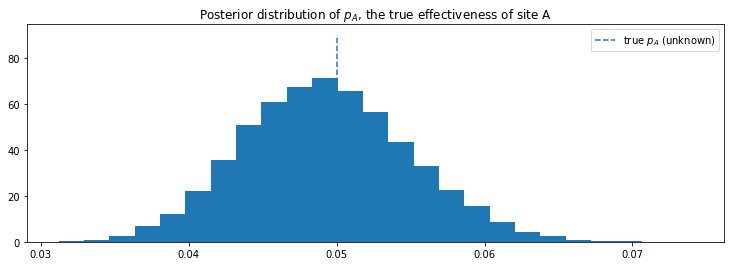

In [6]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend()

### A 与 B 的结合
其实 B 的真实转化率的求法和上面相同，并且本实验真正需要我们求的是 $P_A$ 和 $P_B$的差距 $deta$ 。接下来，让我们一次性将这些变量的分布都求出来吧。此时 $deta$ 就是一个确定型变量，因为 $deta = P_A - P_B$。

In [7]:
# 两个网站的真实转化率
true_p_A = 0.05
true_p_B = 0.04

# 两个网站的访问人数
N_A = 1500
N_B = 750

# 产生观测数据
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [8]:
model = pm.Model()
with model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    # 定义两个转化率的差距
    delta = pm.Deterministic("delta", p_A - p_B)

    # 真实数据传入模型s
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # 模型训练，将在在后面的实验进行解释
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
p_B_samples.shape

(76000,)

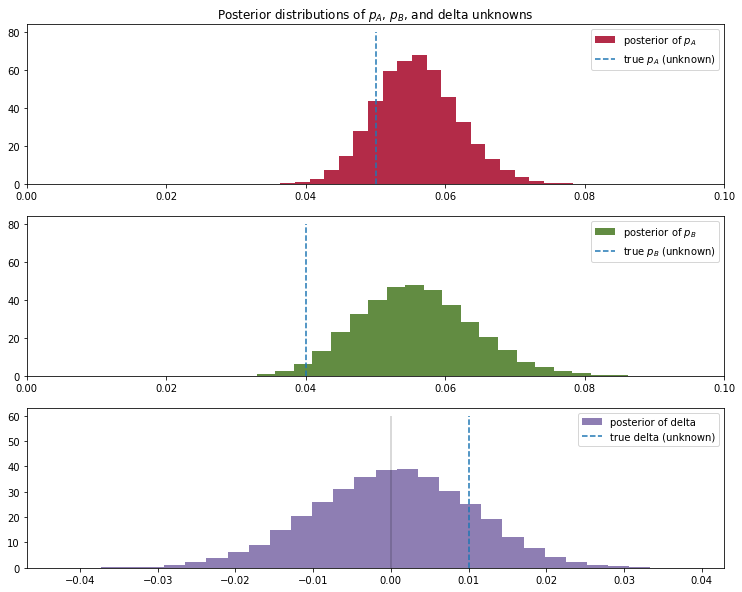

In [11]:
figsize(12.5, 10)

# 利用 histogram 做出每个值的取值概率

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right")

从第三张 $deta$ 图中可以发现，$deta>0$ 的阴影部分面积远远大于小于零的面积。（由于采样的随机性，也可能有很小很小的概率造成，面积相差不大，这时请重复运行上上上段，模型学习的代码）。因此，可以说明，网站 A 确实比网站 B 的转化率更好。这种推断也可以转换成具体的概率值,如下所示：

In [12]:
print("A 网站的转化率比 B 差的概率: %.3f" %
      np.mean(delta_samples < 0))

print("A 网站的转化率比 B 好的概率: %.3f" %
      np.mean(delta_samples > 0))

A 网站的转化率比 B 差的概率: 0.486
A 网站的转化率比 B 好的概率: 0.514


如果这个概率值过高，我们也可以对网站 B 进行更多的试验。因为网站 B 的样本比较少，这将导致网站 B 的每个新的点击数据会比网站 A 的每个新的点击数据有更高的贡献度。

我们也可以对 true_p_A、true_p_B、N_A 和 N_B 设置不同的值，观察 $delta$ 的后验分布情况，进而能够很好的量化网站 A 和网站 B 的优劣。

本实验首先介绍了 A/B 测试的概念，然后利用网站的转换率来进行评估。首先我们为两个网站的转换率设定了均匀先验分布，然后利用伯努利分布模拟真实数据的产生，接下来，将模拟出来的数据和模型相结合，计算出来了每个网站的转换率的后验分布，即转换率的真实分布。最后定义了一种比较两个转换率分布的方法，来判断哪个网站更加吸引用户。